In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from src.utils.feature_engineering import compute_ratio_columnwise

In [2]:
#Training Data
app_train = pd.read_csv('../data/raw/app_train.csv')
#app_test  = pd.read_csv('../data/raw/app_test.csv')


In [3]:
categorical_features = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',\
                        'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE',\
                        'WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE',]

numerical_features =   ['CNT_CHILDREN','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_EMAIL',\
                       'CNT_FAM_MEMBERS','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_LIVE_REGION',\
                       'REG_REGION_NOT_WORK_REGION','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','FLAG_DOCUMENT_2',\
                       'FLAG_DOCUMENT_3','FLAG_DOCUMENT_6','FLAG_DOCUMENT_8','AMT_REQ_CREDIT_BUREAU_HOUR',\
                       'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_QRT',\
                        'REGION_POPULATION_RELATIVE','employment_years','DAYS_REGISTRATION','DAYS_ID_PUBLISH',\
                        'HOUR_APPR_PROCESS_START','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_LAST_PHONE_CHANGE',\
                        'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_YEAR',\
                        'AMT_CREDIT_AMT_INCOME_TOTAL_ratio','Client_Age','AMT_ANNUITY_AMT_INCOME_TOTAL_ratio',\
                        'AMT_CREDIT_AMT_GOODS_PRICE_ratio','employment_age']


Target = "TARGET"

primary_key = "SK_ID_CURR" 


In [4]:
def app_data_processing(df):
    # Lets remove CODE_GENDER=XNA
    df = df.loc[df['CODE_GENDER'] != 'XNA']
    # Apply function
    df['AMT_ANNUITY_AMT_INCOME_TOTAL_ratio'] = compute_ratio_columnwise(df, 'AMT_ANNUITY', 'AMT_INCOME_TOTAL')
    # Apply function
    df['AMT_CREDIT_AMT_INCOME_TOTAL_ratio'] = compute_ratio_columnwise(df, 'AMT_CREDIT', 'AMT_INCOME_TOTAL')
    # Apply function
    df['AMT_CREDIT_AMT_GOODS_PRICE_ratio'] = compute_ratio_columnwise(df, 'AMT_CREDIT', 'AMT_GOODS_PRICE')
    df["Client_Age"] = (df["DAYS_BIRTH"]/(-365)).round(2)
    df['employment_years'] = np.where(df['DAYS_EMPLOYED'] < 0,  (df["DAYS_EMPLOYED"] / -365).round(2),  np.nan)
    df["employment_age"] = np.where(df["employment_years"].isna(),  -1,  
                              np.where(df["Client_Age"] > df["employment_years"],\
                                        df["Client_Age"] - df["employment_years"], -2) 
                                # f1 > f2 -> f1 - f2, else NaN
                                )
    df['AMT_CREDIT_AMT_ANNUITY_ratio'] = compute_ratio_columnwise(df, 'AMT_CREDIT', 'AMT_ANNUITY')     
    df = df[categorical_features + numerical_features + [Target,primary_key]] 
    df[categorical_features] = df[categorical_features].astype('category')
    

    return df                     

In [5]:
app_train= app_data_processing(app_train)
#app_test = app_data_processing(app_test)

In [8]:
app_train.shape


(215255, 47)

### SHAP-BASED Feature SELECTION
SHAP (SHapley Additive exPlanations) values provide one of the most robust approaches for feature selection with XGBoost.


In [6]:
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from src.utils.feature_selection import shap_feature_selection


In [7]:
features=numerical_features+categorical_features
Target = "TARGET"

In [8]:
selected_features,importance_df =shap_feature_selection(train_data=app_train,feature_names=features,target_name=Target,verbose=True)

scale_pos_weight: 11.3874
Detected 8 categorical features: ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
[0]	validation_0-aucpr:0.17089
[1]	validation_0-aucpr:0.17941
[2]	validation_0-aucpr:0.17951
[3]	validation_0-aucpr:0.18220
[4]	validation_0-aucpr:0.18609
[5]	validation_0-aucpr:0.18949
[6]	validation_0-aucpr:0.18966
[7]	validation_0-aucpr:0.18989
[8]	validation_0-aucpr:0.19048
[9]	validation_0-aucpr:0.19219
[10]	validation_0-aucpr:0.19327
[11]	validation_0-aucpr:0.19558
[12]	validation_0-aucpr:0.19682
[13]	validation_0-aucpr:0.19788
[14]	validation_0-aucpr:0.19880
[15]	validation_0-aucpr:0.20113
[16]	validation_0-aucpr:0.20143
[17]	validation_0-aucpr:0.20241
[18]	validation_0-aucpr:0.20436
[19]	validation_0-aucpr:0.20534
[20]	validation_0-aucpr:0.20572
[21]	validation_0-aucpr:0.20561
[22]	validation_0-aucpr:0.20656
[23]	validation_0-aucpr:0.20742
[24]	validati

In [10]:
app_train[selected_features].dtypes

EXT_SOURCE_3                           float64
EXT_SOURCE_2                           float64
EXT_SOURCE_1                           float64
AMT_CREDIT_AMT_GOODS_PRICE_ratio       float64
employment_years                       float64
ORGANIZATION_TYPE                     category
NAME_EDUCATION_TYPE                   category
Client_Age                             float64
AMT_ANNUITY_AMT_INCOME_TOTAL_ratio     float64
FLAG_OWN_CAR                          category
DAYS_ID_PUBLISH                          int64
FLAG_DOCUMENT_3                          int64
REGION_RATING_CLIENT_W_CITY              int64
DEF_30_CNT_SOCIAL_CIRCLE               float64
DAYS_LAST_PHONE_CHANGE                 float64
dtype: object

In [9]:
selected_features

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'AMT_CREDIT_AMT_GOODS_PRICE_ratio',
 'employment_years',
 'ORGANIZATION_TYPE',
 'NAME_EDUCATION_TYPE',
 'Client_Age',
 'AMT_ANNUITY_AMT_INCOME_TOTAL_ratio',
 'FLAG_OWN_CAR',
 'DAYS_ID_PUBLISH',
 'FLAG_DOCUMENT_3',
 'REGION_RATING_CLIENT_W_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE']

In [157]:
shap_values = explainer.shap_values(X_train)

In [158]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

In [67]:
y_pred_b= model.predict_proba(X_test)[:,1]

In [69]:
len(y_pred_b)

64577

In [72]:
auc_b = roc_auc_score(y_test,y_pred_b)
auc_b

np.float64(0.7449753409082805)

In [75]:
model_s = xgb.XGBClassifier(
                n_estimators=100, 
                learning_rate=0.05,
                max_depth=4,
                random_state=42,
                eval_metric = 'aucpr',enable_categorical=True)
    
model_s.fit(X_train[selected_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [76]:
y_pred_a= model_s.predict_proba(X_test[selected_features])[:,1]

In [77]:
auc_a = roc_auc_score(y_test,y_pred_a)
auc_a

np.float64(0.7442115977000661)

In [89]:
explainer = shap.TreeExplainer(model_s)

In [91]:
shap_values = explainer.shap_values(X_test[selected_features])

In [93]:
shap_values.shape

(64577, 13)

tuple

In [95]:
# print the JS visualization code to the notebook
shap.initjs()

In [96]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test[selected_features].iloc[0, :])

In [ ]:
1/(1+np.exp(- explainer.shap_values(X_test[selected_features].iloc[0:1,:])))


array([[0.5164693 , 0.39846978, 0.5098487 , 0.4906576 , 0.5201898 ,
        0.4822249 , 0.5130377 , 0.48086444, 0.5076199 , 0.48663962,
        0.4956851 , 0.5012622 , 0.4726498 ]], dtype=float32)

In [144]:

explainer.shap_values(X_test[selected_features].iloc[0:1,:])

array([[ 0.0659011 , -0.41184515,  0.03939995, -0.03737412,  0.0808033 ,
        -0.07113039,  0.05216241, -0.07657965,  0.03048193, -0.05345416,
        -0.01726007,  0.0050488 , -0.10951001]], dtype=float32)

In [115]:
selected_features

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'AMT_CREDIT_AMT_GOODS_PRICE_ratio',
 'ORGANIZATION_TYPE',
 'employment_years',
 'NAME_EDUCATION_TYPE',
 'Client_Age',
 'AMT_ANNUITY_AMT_INCOME_TOTAL_ratio',
 'FLAG_DOCUMENT_3',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_OWN_CAR',
 'REGION_RATING_CLIENT_W_CITY']

In [113]:
explainer.expected_value-0.50335604

np.float32(-2.947559)

In [146]:

def log_odds_to_probability(log_odds):
    return 1 / (1 + np.exp(-log_odds))

# Example
log_odds = -0.10951001 # Example log-odds value
probability = log_odds_to_probability(log_odds)
print(probability)  # Output: ~0.88

0.47264982498803393


In [134]:
#y_test.mean()
0.07987842623285228-0.04973651155855672


0.030141914674295563

In [139]:
-0.50335604+(-2.444)

-2.94735604

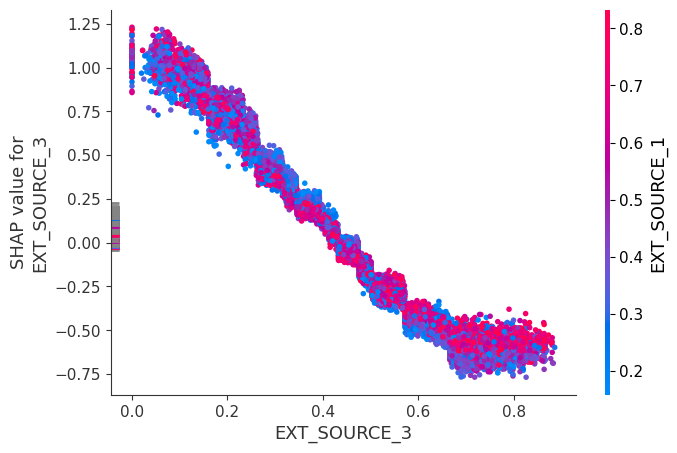

In [97]:
shap.dependence_plot('EXT_SOURCE_3', shap_values, X_test[selected_features], display_features=X_test[selected_features])

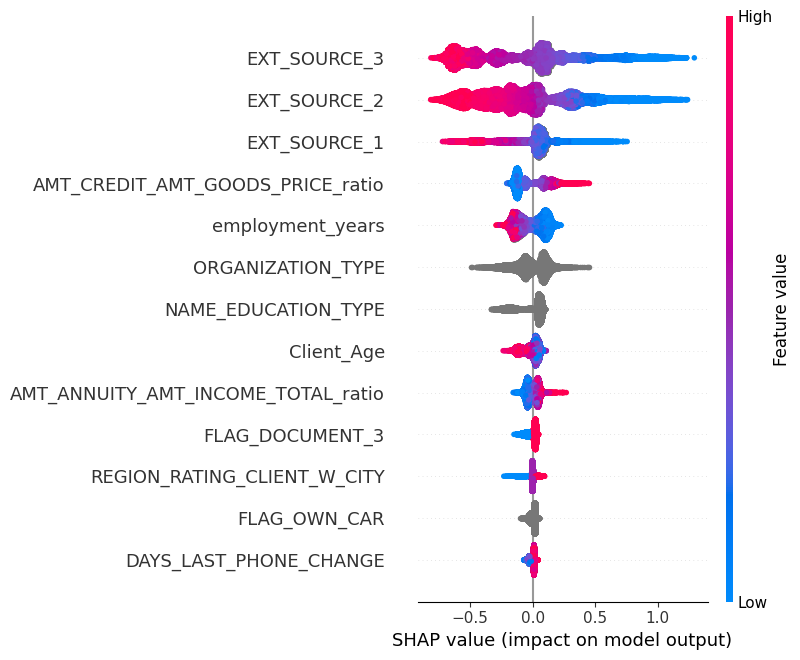

In [92]:
# Visualize feature importance based on SHAP
shap.summary_plot(shap_values, X_test[selected_features])

In [84]:
### Kaggle Test Data score check
test_kaggle = pd.read_csv("../data/raw/application_test.csv")
test_kaggle['TARGET']=0

In [85]:
test_kaggle = app_data_processing(test_kaggle)
#app_test = app_data_processing(app_test)

In [86]:
y_pred_k= model_s.predict_proba(test_kaggle[selected_features])[:,1]

In [88]:
submit=test_kaggle[["SK_ID_CURR"]]
submit['TARGET']=y_pred_k
submit.to_csv('../data/Kaggle_submission/1.XGB_baseline_app_features.csv',index=False)